---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [147]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd
from zipfile import ZipFile

# Utils
from tqdm import tqdm

# sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score)

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

In [2]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [3]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


# <font color='#4C5FDA'> **1. Creación del DataFrame**</color> <a name="tema2">


In [8]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


In [9]:
#@title **Función para obtener una muestra**

def get_sample(tipo:float):

  sample = data[(data['label']==tipo)].sample(1)

  if tipo == 1.0:
    tipo = 'Parkinson'
  else:
    tipo = 'Control'
  sample = [sample['audio_path'].item(), sample['frames_path'].item(), tipo]
  return sample

#  <font color='#4C5FDA'> **2. Preprocesamiento de los datos 🧐**</color> <a name="tema7">


## <font color='#EB9A54'>**2.1 Extracción de características para la hipomimia**</font> <a name = "tema8">

### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [14]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [15]:
def preprocess_frame(frame_path: str):
  frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # Leemos la imagen desde la ruta en escala de grises
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # La pasamos de BGR a RGB
  frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
  frame = frame / 255. # Normalizamos entre 0 y 1
  return frame.flatten()
  # return frame

Cuando aplicamos concatenate(), todos los valores de los píxeles de los frames se concatenan en una única secuencia lineal. El orden es: primero todos los valores del primer frame, seguidos por todos los valores del segundo frame, y así sucesivamente.

In [16]:
def preprocess_video(video_path: str, n_frames = FRAMES_PROMEDIO):
  frames = []
  for frame in sorted(os.listdir(video_path))[:n_frames]:
    frames.append(preprocess_frame(f"{video_path}/{frame}"))
  return np.concatenate(frames)
  # return frames

In [17]:
sample_preprocessed_video = get_sample(1.0)[1] # Obtengo la ruta de un vídeo
sample_preprocessed_video = preprocess_video(sample_preprocessed_video) # Aplico la función de preprocesamiento

In [18]:
sample_preprocessed_video.shape #14×112×112×1=175616

(175616,)

### <font color="52F17F">**Aplicar el preprocesamiento a todos los vídeos**</font>

In [19]:
# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_frame_sequence'] = data['frames_path'].apply(preprocess_video)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence
patient,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [20]:
data['flatten_frame_sequence'][0].shape

(175616,)

## <font color='#EB9A54'>**2.2 Fusión de características**</font> <a name = "tema8">

### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [21]:
def preprocess_and_fuse(flatten_frame_sequence, flatten_log_mel_spectogram):
    """
    Esta función concatena los frames aplanados y el espectrograma mel aplanado.

    Args:
        flatten_frame_sequence: array de frames aplanados.
        flatten_log_mel_spectogram: array de espectrograma mel aplanado.

    Returns:
        fused_features: Un array que contiene la concatenación de los frames y el espectrograma mel.
    """
    # Concatenar los frames y el espectrograma mel
    return np.concatenate([flatten_frame_sequence, flatten_log_mel_spectogram])

In [22]:
random_idx = np.random.choice(range(1, len(data)))
sample_fusioned = data[['flatten_frame_sequence', 'flatten_log_mel_spectogram']].iloc[random_idx].values
sample_fusioned.shape

(2,)

In [23]:
sample_fusioned = preprocess_and_fuse(sample_fusioned[0], sample_fusioned[1])
sample_fusioned.shape # Debería ser (14 * 112 * 112 + 900,)

(176516,)

### <font color="52F17F">**Aplicar la fusión a todos los registros**</font>

In [24]:
# Fusionar todas las características aplanadas
data['fused_flattened_features'] = data.apply(
    lambda row: preprocess_and_fuse(row['flatten_frame_sequence'], row['flatten_log_mel_spectogram']),
    axis=1
)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features
patient,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [25]:
data['fused_flattened_features'][0].shape

(176516,)

## <font color='#EB9A54'>**2.3 PCA**</font> <a name = "tema8">

In [26]:
pca = PCA(n_components=2)

In [27]:
converted = pca.fit_transform(np.vstack(data['flatten_log_mel_spectogram']))
converted = [row for row in converted]
data['pca_flatten_log_mel_spectogram'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram
patient,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.8745374390995, 39.47367500354504]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984335, 109.9563038644905]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.4566435567151, 48.46460588402894]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596388, -30.18549325731931]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379573, 92.81292282760441]"


In [28]:
pca = PCA(n_components=14*2)

In [29]:
converted = pca.fit_transform(np.vstack(data['flatten_frame_sequence']))
converted = [row for row in converted]
data['pca_flatten_frame_sequence'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram,pca_flatten_frame_sequence
patient,,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.8745374390995, 39.47367500354504]","[-4.595280588133166, 24.683745586722935, 6.690..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984335, 109.9563038644905]","[-3.864669403017923, 22.54283968410986, 7.2301..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.4566435567151, 48.46460588402894]","[-4.720198557822541, 23.372722364432466, 5.340..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596388, -30.18549325731931]","[1.1824708722401838, 26.165804987624693, 9.049..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379573, 92.81292282760441]","[-2.6796593130356903, 24.02922166354199, 6.856..."


# <font color='#4C5FDA'> **3. Non-supervised 🦾**</color> <a name="tema8">

In [232]:
algorithms = [
    ('kmeans', KMeans(n_clusters=2, n_init='auto')),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5)),
    ('ACWard', AgglomerativeClustering(n_clusters=2, linkage="ward")),
    ('ACAverage', AgglomerativeClustering(n_clusters=2, linkage="average")),
    ('ACSingle', AgglomerativeClustering(n_clusters=2, linkage="single")),
]

In [221]:
def calculate_metrics(y_true, y_pred):
    metrics = {}

    accuracy = np.round(accuracy_score(y_true, y_pred), 3)
    f1 = np.round(f1_score(y_true, y_pred), 3)
    precision = np.round(precision_score(y_true, y_pred), 3)
    recall = np.round(recall_score(y_true, y_pred), 3)

    metrics['accuracy'] = accuracy
    metrics['f1_score'] = f1
    metrics['precision'] = precision
    metrics['recall'] = recall

    return metrics

## <font color='#EB9A54'> **3.1 Solo Audio Features**</color> <a name="tema8">

### <font color='#52F17F'> **3.1.1 Pruebas Individual**</color> <a name="tema9">

In [234]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [235]:
X = np.array(data['pca_flatten_log_mel_spectogram'].tolist())
y = data['label'].values

In [236]:
np.vstack(data['pca_flatten_log_mel_spectogram']) # Same as X

array([[-146.87453744,   39.473675  ],
       [-214.1628683 ,  109.95630386],
       [-271.45664356,   48.46460588],
       ...,
       [ 194.42517016,  -10.07212753],
       [ -46.49024848,  -18.78278014],
       [  91.66636565,  -12.83191791]])

In [237]:
kmeans.fit(np.vstack(data['pca_flatten_log_mel_spectogram'])) # Same as training with X

KMeans(n_clusters=2, n_init='auto')

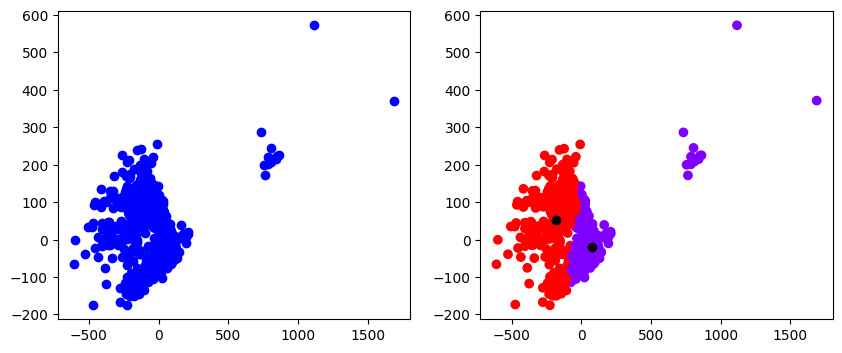

In [238]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c="blue");
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

In [239]:
clusters = kmeans.fit_predict(X)

In [240]:
print(np.array(clusters).shape)

(1091,)


In [241]:
# def calculate_metrics(tn:int, fp:int, fn:int, tp:int):
#   precision = np.round((tp/(tp+fp)*100),2)
#   recall = np.round((tp/(tp+fn)*100),2)

#   if(tp+tn+fp+fn == 0):
#     accuracy = 0
#   else:
#     accuracy = np.round(((tp+tn)/(tp+tn+fp+fn))*100, 2)

#   if((precision and recall) == 0):
#     f1_score = 0
#   else:
#     f1_score = np.round((2*((precision*recall)/(precision+recall))),2)

#   return accuracy, precision, recall, f1_score

### <font color='#52F17F'> **3.1.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

In [243]:
for alg in algorithms:
  try:
    clusters = alg[1].fit_predict(X)
    metrics = calculate_metrics(y, clusters)
    print(f"{11*'='} Resultados para {alg[0]} {11*'='}")
    for metric, score in metrics.items():
      print(f"  {metric}: {np.mean(score)*100:.2f}%")
    print("")
  except:
    print(f"{11*'='} Error para {alg[0]} {11*'='}")
    print("")


=========== Resultados para kmeans ===========
  accuracy: 43.40%
  f1_score: 53.30%
  precision: 45.40%
  recall: 64.60%

=========== Error para DBSCAN ===========

=========== Resultados para ACWard ===========
  accuracy: 56.50%
  f1_score: 45.30%
  precision: 60.80%
  recall: 36.10%

=========== Resultados para ACAverage ===========
  accuracy: 50.40%
  f1_score: 66.70%
  precision: 50.20%
  recall: 99.30%

=========== Resultados para ACSingle ===========
  accuracy: 50.00%
  f1_score: 0.00%
  precision: 0.00%
  recall: 0.00%



---

## <font color='#EB9A54'> **3.2 Solo Video Features**</color> <a name="tema8">

### <font color='#52F17F'> **3.2.1 Pruebas Individual**</color> <a name="tema8">

In [244]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [245]:
X = np.array(data['pca_flatten_frame_sequence'].tolist())
y = data['label'].values

In [246]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

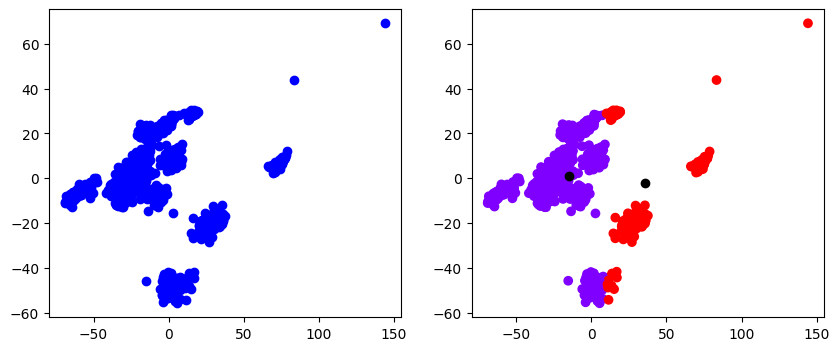

In [247]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c="blue");
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

In [248]:
clusters = kmeans.fit_predict(X)
print(np.array(clusters).shape)

(1091,)


### <font color='#52F17F'> **3.2.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

In [249]:
for alg in algorithms:
  try:
    clusters = alg[1].fit_predict(X)
    metrics = calculate_metrics(y, clusters)
    print(f"{11*'='} Resultados para {alg[0]} {11*'='}")
    for metric, score in metrics.items():
      print(f"  {metric}: {np.mean(score)*100:.2f}%")
    print("")
  except:
    print(f"{11*'='} Error para {alg[0]} {11*'='}")
    print("")


=========== Resultados para kmeans ===========
  accuracy: 57.30%
  f1_score: 50.20%
  precision: 60.10%
  recall: 43.10%

=========== Error para DBSCAN ===========

=========== Resultados para ACWard ===========
  accuracy: 64.30%
  f1_score: 54.70%
  precision: 74.80%
  recall: 43.10%

=========== Resultados para ACAverage ===========
  accuracy: 50.00%
  f1_score: 0.40%
  precision: 50.00%
  recall: 0.20%

=========== Resultados para ACSingle ===========
  accuracy: 50.00%
  f1_score: 66.60%
  precision: 50.00%
  recall: 99.80%



## <font color='#EB9A54'> **3.3 Fusion of features**</color> <a name="tema8">

- PCA para las variables juntas, probar diferentes configuraciones.
- Preguntarle a Guillermo que mas añadirle, o si directamente toca preguntar en clase al profe.
- Recibir el Feedback de Guillermo.